# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.impute import SimpleImputer

# Data Loading

In [2]:
#source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', header=0, index_col=0)
df

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland
1744-02-01,NaN,NaN,Åland
1744-03-01,NaN,NaN,Åland
...,...,...,...
2013-05-01,19.059,1.022,Zimbabwe
2013-06-01,17.613,0.473,Zimbabwe
2013-07-01,17.000,0.453,Zimbabwe


In [3]:
df_train = df.loc[df['Country'].isin(['Indonesia'])]
display(df_train)

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1825-01-01,25.915,1.825,Indonesia
1825-02-01,25.385,0.973,Indonesia
1825-03-01,25.687,1.656,Indonesia
1825-04-01,26.302,1.897,Indonesia
1825-05-01,25.705,0.902,Indonesia
...,...,...,...
2013-05-01,26.818,0.154,Indonesia
2013-06-01,26.881,0.248,Indonesia
2013-07-01,25.902,0.164,Indonesia


In [4]:
df_train=df_train.iloc[:,0:1]
df_train

,AverageTemperature
dt,
1825-01-01,25.915
1825-02-01,25.385
1825-03-01,25.687
1825-04-01,26.302
1825-05-01,25.705
...,...
2013-05-01,26.818
2013-06-01,26.881
2013-07-01,25.902


# Data Prepocessing

In [5]:
#Menghitung nilai null
df_train.isnull().sum()

AverageTemperature    386
dtype: int64

In [6]:
#Mengganti nilai null
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
miss_mean_imputer = miss_mean_imputer.fit(df_train)
df_train_imputed = miss_mean_imputer.transform(df_train.values)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  "X does not have valid feature names, but"


In [7]:
#Memisahkan data tanggal dan data temperatur
date = df_train.reset_index(level=0)
date = date['dt']

values = df_train_imputed
temp = values.reshape((len(values), 1))

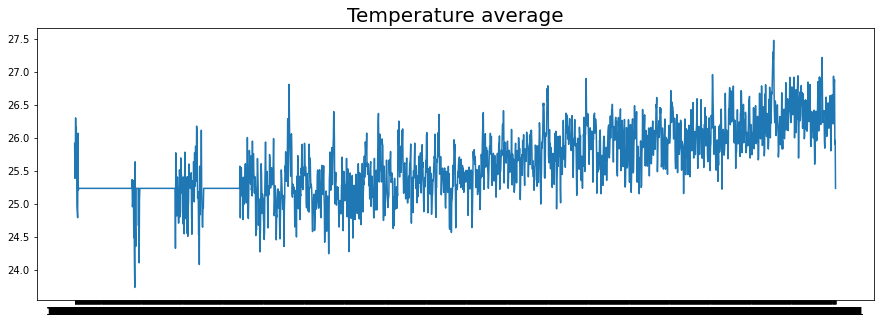

In [8]:
plt.figure(figsize=(15,5))
plt.plot(date, temp)
plt.title('Temperature average',
          fontsize=20);

In [9]:
#Normalisasi data temperatur dengan MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(temp)
temp_normalized = scaler.transform(temp)
temp_normalized

array([[0.58297759],
       [0.44156884],
       [0.52214514],
       ...,
       [0.57950907],
       [0.5952508 ],
       [0.40101387]])

In [10]:
#Menghitung nilai ambang batas dari data
threshold_mae = (temp_normalized.max() - temp_normalized.min()) * 10/100
print(threshold_mae)

0.1


# Splitting and Transform Data

In [11]:
x_train, x_test, y_train, y_test = train_test_split(temp_normalized, date, test_size = 0.2, shuffle = False )

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=32, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=64, batch_size=32, shuffle_buffer=1000)

# Modeling

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(64,1)),

  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.09),
  tf.keras.layers.Dense(1),
])

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    validation_data = val_set, 
                    epochs=100,                  
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


55/55 [==============================] - 5s 28ms/step - loss: 0.1311 - mae: 0.4986 - val_loss: 0.2476 - val_mae: 0.6975
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 0.1024 - mae: 0.4377 - val_loss: 0.2077 - val_mae: 0.6377
Epoch 3/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0806 - mae: 0.3850 - val_loss: 0.1760 - val_mae: 0.5860
Epoch 4/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0636 - mae: 0.3381 - val_loss: 0.1489 - val_mae: 0.5378
Epoch 5/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0509 - mae: 0.2987 - val_loss: 0.1277 - val_mae: 0.4968
Epoch 6/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0410 - mae: 0.2644 - val_loss: 0.1106 - val_mae: 0.4610
Epoch 7/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0327 - mae: 0.2313 - val_loss: 0.0947 - val_mae: 0.4253
Epoch 8/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0262 - mae: 

# Plotting Validation

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


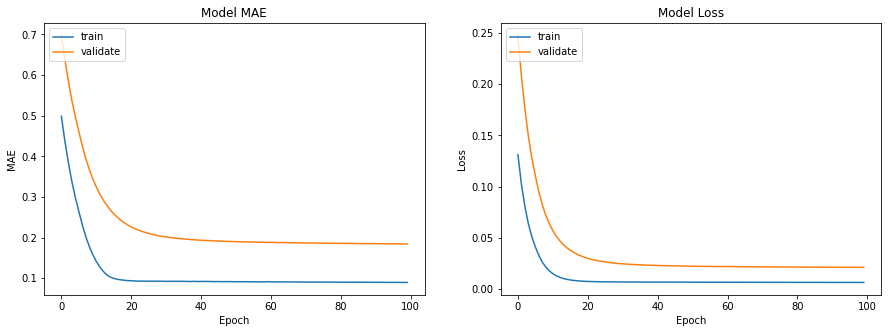

In [16]:
#membuat grafik model accuracy dan model loss
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # menjumlahkan nilai accuracy
    axs[0].plot(history.history['mae']) 
    axs[0].plot(history.history['val_mae']) 
    axs[0].set_title('Model MAE')
    axs[0].set_ylabel('MAE') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # menjumlahkan nilai loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


print(history.history.keys())
plotmodelhistory(history)